a bit DIY here
- [ ] for each star of interest
- [x] pull LCs from lightkurve
- [x] for each LC, do some simple iterative detrending & flare finding
- [x] mind the gaps
- [x] combine the close events
- [x] tune this for the data in hand, not in general
- [ ] save flare catalog/table for every star

hopefully can steal chunks of this code from the HelloTESS stuff?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.table import Table
# from scipy.signal import savgol_filter
# from scipy.interpolate import CubicSpline

from stuff import *
import exoplanet as xo

import sys
sys.path.append('/Users/james/Dropbox/research_projects/FFD/')
from FFD import FFD

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
FS = pd.read_csv('flare_sample_step1.csv')
FS

,KIC,TIC,Nfl,K1min,K30min,T2min
0,11143395,27236187,2,0.0,1.0,2.0
1,11495571,48504458,2,0.0,15.0,1.0
2,6117602,122136861,2,0.0,17.0,3.0
3,8408875,123229811,2,0.0,4.0,2.0
4,8682921,159047957,2,1.0,18.0,2.0
5,8429280,159721038,3,1.0,18.0,3.0
6,9153754,159761686,3,0.0,4.0,2.0
7,9201463,164458193,3,0.0,17.0,4.0
8,7505473,164463430,3,0.0,4.0,4.0
9,7341653,164644375,11,0.0,16.0,4.0


In [4]:
# TESS 2-min DATA
for k in range(len(FS)):
    lc_k = lk.search_lightcurve('TIC'+str(FS['TIC'].values[k]), mission='TESS', exptime=120)

    for j in range(len(lc_k)):
        lc = lc_k[j].download()


        # make harsh quality cuts, and chop out a known bad window of time (might add more later)
        AOK = (lc['quality'].data == 0) & ((lc['time'].value < 1347) | (lc['time'].value > 1350))
        med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
        xtr = 5

        # ACF w/ Exoplanet package
        acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                                    yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                                    min_period=0.07, max_period=27, max_peaks=2)
        if len(acf['peaks']) > 0:
            ACF_1dt = acf['peaks'][0]['period']
            ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

            scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
            s_window = int(ACF_1dt / scl / xtr)
        else:
            s_window = 128

        # window must be odd for some smooth approaches
        if (s_window % 2) == 0:
            s_window -= 1

        yerr = lc['pdcsap_flux_err'].value[AOK] / med
        x = lc['time'].value[AOK]
        y = (lc['pdcsap_flux'].value[AOK] - med)/med


        # find flares
        FM, xhat, yhat = iflare(x, y, yerr, s_window, npass=6)

        if sum(FM) > 0:
            # split the flares into start/stops
            istart, istop = flaresplit(FM, dlim=5)

            # measure equiv durations (energies)
            ED = np.zeros(len(istart), dtype=float)
            EDerr = np.zeros(len(istart), dtype=float)
            for l in range(len(istart)):
                ED[l], EDerr[l] = EquivDur(x,y,yerr, xhat,yhat, istart[l],istop[l])

            # compute FFD properties for this star
            TOTEXP = np.nanmedian(np.diff(lc.time.value)) * len(x)
            ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ED, TOTEXP=TOTEXP, 
                                                   Lum=0., fluxerr=np.nanmedian(yerr), 
                                                   dur = x[istop]-x[istart])
            # sort flares like FFD does
            ss = np.argsort(np.array(ED))[::-1]
            # save flare properties for this light curve
            df = pd.DataFrame(data={'tstart':x[istart][ss]+ 2457000, 'tstop':x[istop][ss] + 2457000, 
                                    'ED':ED[ss], 'EDerr':EDerr[ss],
                                    'ffd_x':ffd_x, 'ffd_y':ffd_y, 
                                    'ffd_xerr':ffd_xerr, 'ffd_yerr':ffd_yerr})


            filename = 'KIC_'+str(FS['KIC'].values[k]) + '_TESS_' + str(lc.SECTOR)
            df.to_csv('../data/'+filename+'.csv', index=False, index_label=False)

            plt.figure(figsize=(6,6))
            plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr, yerr=ffd_yerr, marker='o', linestyle='none', 
                         label='N='+str(len(ffd_x)))
            plt.legend()
            plt.title(filename, fontsize=12)
            plt.xlabel('log Equivalent Duration (s)')
            plt.ylabel('log Flare Rate (per day)')
            plt.savefig('../figures/'+filename+'_ffd.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()
            
            plt.figure(figsize=(13,4))
            plt.plot(x,y)
            plt.plot(xhat,yhat)
            plt.title(filename, fontsize=12)
            plt.savefig('../figures/'+filename+'_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()

In [5]:
# Kepler 1-min DATA
for k in range(len(FS)):
    lc_k = lk.search_lightcurve(str(FS['KIC'].values[k]), mission='Kepler', exptime=60)

    for j in range(len(lc_k)):
        lc = lc_k[j].download()


        # make harsh quality cuts, and chop out a known bad window of time (might add more later)
        AOK = (lc['quality'].data == 0) & np.isfinite(lc['pdcsap_flux'].value) & ((lc['time'].value < 1347) | (lc['time'].value > 1350))
        med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
        xtr = 5

        # ACF w/ Exoplanet package
        acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                                    yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                                    min_period=0.07, max_period=27, max_peaks=2)
        if len(acf['peaks']) > 0:
            ACF_1dt = acf['peaks'][0]['period']
            ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

            scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
            s_window = int(ACF_1dt / scl / xtr)
        else:
            s_window = 128

        # window must be odd for some smooth approaches
        if (s_window % 2) == 0:
            s_window -= 1

        yerr = lc['pdcsap_flux_err'].value[AOK] / med
        x = lc['time'].value[AOK]
        y = (lc['pdcsap_flux'].value[AOK] - med)/med


        # find flares
        FM, xhat, yhat = iflare(x, y, yerr, s_window, npass=6)

        if sum(FM) > 0:
            # split the flares into start/stops
            istart, istop = flaresplit(FM, dlim=5)

            # measure equiv durations (energies)
            ED = np.zeros(len(istart), dtype=float)
            EDerr = np.zeros(len(istart), dtype=float)
            for l in range(len(istart)):
                ED[l], EDerr[l] = EquivDur(x,y,yerr, xhat,yhat, istart[l],istop[l])

            # compute FFD properties for this star
            TOTEXP = np.nanmedian(np.diff(lc.time.value)) * len(x)
            ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ED, TOTEXP=TOTEXP, 
                                                   Lum=0., fluxerr=np.nanmedian(yerr), 
                                                   dur = x[istop]-x[istart])
            # sort flares like FFD does
            ss = np.argsort(np.array(ED))[::-1]
            # save flare properties for this light curve
            df = pd.DataFrame(data={'tstart':x[istart][ss]+ 2455000, 'tstop':x[istop][ss]+ 2455000, 
                                    'ED':ED[ss], 'EDerr':EDerr[ss],
                                    'ffd_x':ffd_x, 'ffd_y':ffd_y, 
                                    'ffd_xerr':ffd_xerr, 'ffd_yerr':ffd_yerr})


            filename = 'KIC_'+str(FS['KIC'].values[k]) + '_KepS_' + str(lc.QUARTER)
            df.to_csv('../data/'+filename+'.csv', index=False, index_label=False)

            plt.figure(figsize=(6,6))
            plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr, yerr=ffd_yerr, marker='o', linestyle='none', 
                         label='N='+str(len(ffd_x)))
            plt.legend()
            plt.title(filename, fontsize=12)
            plt.xlabel('log Equivalent Duration (s)')
            plt.ylabel('log Flare Rate (per day)')
            plt.savefig('../figures/'+filename+'_ffd.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()
            
            plt.figure(figsize=(13,4))
            plt.plot(x,y)
            plt.plot(xhat,yhat)
            plt.title(filename, fontsize=12)
            plt.savefig('../figures/'+filename+'_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()

In [11]:
# Kepler 30-min DATA
for k in range(len(FS)):
    lc_k = lk.search_lightcurve(str(FS['KIC'].values[k]), mission='Kepler', exptime=1800)

    for j in range(len(lc_k)):
        lc = lc_k[j].download()

        # make harsh quality cuts, and chop out a known bad window of time (might add more later)
        AOK = (lc['quality'].data == 0) & np.isfinite(lc['pdcsap_flux'].value)
        med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
        xtr = 5

        # ACF w/ Exoplanet package
        acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                                    yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                                    min_period=0.07, max_period=27, max_peaks=2)
        if len(acf['peaks']) > 0:
            ACF_1dt = acf['peaks'][0]['period']
            ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

            scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
            s_window = int(ACF_1dt / scl / xtr)
        else:
            s_window = 6

        if s_window < 6:
            s_window = 6

        # window must be odd for some smooth approaches
        if (s_window % 2) == 0:
            s_window -= 1

        yerr = lc['pdcsap_flux_err'].value[AOK] / med
        x = lc['time'].value[AOK]
        y = (lc['pdcsap_flux'].value[AOK] - med)/med


        # find flares
        FM, xhat, yhat = iflare(x, y, yerr, s_window, npass=10, N3=1, N1=1, N2=1)

        if sum(FM) > 0:
            # split the flares into start/stops
            istart, istop = flaresplit(FM, dlim=7)

            # measure equiv durations (energies)
            ED = np.zeros(len(istart), dtype=float)
            EDerr = np.zeros(len(istart), dtype=float)
            for l in range(len(istart)):
                if istop[l] == istart[l]:
                    istop[l] += 1
                ED[l], EDerr[l] = EquivDur(x,y,yerr, xhat,yhat, istart[l],istop[l])

            # compute FFD properties for this star
            TOTEXP = np.nanmedian(np.diff(lc.time.value)) * len(x)
            ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ED, TOTEXP=TOTEXP, 
                                                   Lum=0., fluxerr=np.nanmedian(yerr), 
                                                   dur = x[istop]-x[istart])
            # sort flares like FFD does
            ss = np.argsort(np.array(ED))[::-1]
            # save flare properties for this light curve
            df = pd.DataFrame(data={'tstart':x[istart][ss]+ 2455000, 'tstop':x[istop][ss]+ 2455000, 
                                    'ED':ED[ss], 'EDerr':EDerr[ss],
                                    'ffd_x':ffd_x, 'ffd_y':ffd_y, 
                                    'ffd_xerr':ffd_xerr, 'ffd_yerr':ffd_yerr})


            filename = 'KIC_'+str(FS['KIC'].values[k]) + '_KepL_' + str(lc.QUARTER)
            df.to_csv('../data/'+filename+'.csv', index=False, index_label=False)

            plt.figure(figsize=(6,6))
            plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr, yerr=ffd_yerr, marker='o', linestyle='none', 
                         label='N='+str(len(ffd_x)))
            plt.legend()
            plt.title(filename, fontsize=12)
            plt.xlabel('log Equivalent Duration (s)')
            plt.ylabel('log Flare Rate (per day)')
            plt.savefig('../figures/'+filename+'_ffd.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()
            
            plt.figure(figsize=(13,4))
            plt.plot(x,y)
            plt.plot(xhat,yhat)
            plt.title(filename, fontsize=12)
            plt.savefig('../figures/'+filename+'_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
            plt.close()

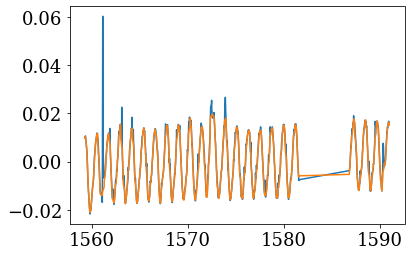

In [12]:
plt.plot(x,y)
plt.plot(xhat,yhat)